# Results rudder velocities

In [1]:
#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = True
#%load_ext kedro.ipython

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.prime_system import PrimeSystem
from phd.visualization.plot_prediction import plot_total_force, plot_force_components, predict, plot_compare_model_forces, plot_parameter_contributions, group_parameters, joined_parameter_contributions, same_ylims
from vessel_manoeuvring_models.symbols import *
import matplotlib.pyplot as plt
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, remove_functions, prime
from vessel_manoeuvring_models.parameters import df_parameters
p = df_parameters["symbol"]
import sympy as sp
from sympy import Eq, symbols, latex
from phd.pipelines.load_wPCC.nodes import preprocess,zigzag_angle
from phd.pipelines.resimulate_with_autopilot.nodes import simulate_closed_loop, postprocess
from phd.visualization.plot_vct import plot_VCT, flat_keys

import paper

from vessel_manoeuvring_models.KF_multiple_sensors import interpolate_and_insert_all
from phd.visualization.units import units
from phd.visualization.symbols import symbols
from phd.pipelines.regression_VCT.nodes import mirror, add_mirrored
from phd.pipelines.regression_VCT.nodes import subtract_centripetal_and_Coriolis
import matplotlib.ticker as plticker
import plotly.graph_objects as go

In [3]:
ship_name = "optiwise"

In [108]:
model = catalog.load(f"{ship_name}.models_VCT_MMG_rudder")["MMG"]()
model.control_keys=['u_R','v_R','delta']
rudder = model.subsystems['rudder']
rudder.lambdas.pop('u_R')
rudder.lambdas.pop('v_R')
rudder.lambdas.pop('C_Th')
rudder.lambdas.pop('V_A')
model.parameters['gamma_0']=0
model.parameters['a_H'] = 0
model.parameters['x_H'] = 0

ship_data = model.ship_parameters.copy()

[11/28/24 10:36:11] INFO     Loading data from 'optiwise.models_VCT_MMG_rudder'                 ]8;id=795332;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=887452;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

In [109]:
def add_zeros(df, zero_test_types = [
        'Circle',
        'Drift angle',
        'Rudder angle',
    ]):

    ## Add zeros:
    #if 'self propulsion' in df['test type']:
    #    df_self_propulsion = df.groupby('test type').get_group('self propulsion')
    #else:
    #    return df
    df_self_propulsion = df.groupby('test type').get_group('self propulsion')
    zero = df_self_propulsion.loc[df_self_propulsion['V'].idxmax()]
    
    _ = []
    for test_type in zero_test_types:
        new_zero = zero.copy()
        new_zero['test type'] = test_type
        _.append(new_zero)
    
    new_zeros = pd.DataFrame(_)
    
    df = pd.concat((df, new_zeros))

    return df

In [110]:
df_VCT = pd.read_csv("../../notebooks/OPTIWISE/df_VCT_velocities_mean_optiwise.csv", index_col=0)

#mask = df_VCT['r'] > 0
#df_VCT.loc[mask,'v_R']*=-1

#df_VCT = add_zeros(df_VCT)

df_VCT['beta_deg'] = np.rad2deg(df_VCT['beta'])
mask = df_VCT['beta_deg'].abs() < 20
df_VCT = df_VCT.loc[mask].copy()

In [111]:
#df_VCT['v_R'] = np.sign(df_VCT['v_R**2'])*np.sqrt(np.abs(df_VCT['v_R**2']))
#df_VCT['u_R'] = np.sign(df_VCT['u_R**2'])*np.sqrt(np.abs(df_VCT['u_R**2']))
#df_VCT['V_R'] = np.sign(df_VCT['V_R**2'])*np.sqrt(np.abs(df_VCT['V_R**2']))

## Scale

In [112]:
lpp_ship = ship_data['L']*ship_data['scale_factor']
rho_ = df_VCT.iloc[0]['rho']
prime_system_ship = PrimeSystem(L=lpp_ship, rho=rho_)

In [113]:
def scale(df):
    units={
        'u_R_port':'linear_velocity',
        'v_R_port':'linear_velocity',
        'V_R_port':'linear_velocity',
        'w_R_port':'linear_velocity',
    
        'u_R_stbd':'linear_velocity',
        'v_R_stbd':'linear_velocity',
        'V_R_stbd':'linear_velocity',
        'w_R_stbd':'linear_velocity',

        'u_R':'linear_velocity',
        'v_R':'linear_velocity',
        'V_R':'linear_velocity',
        'w_R':'linear_velocity',
        
        'V_R_port**2':"linear_velocity**2",
        'u_R_port**2':"linear_velocity**2",
        'v_R_port**2':"linear_velocity**2",
        'V_R_stbd**2':"linear_velocity**2",
        'u_R_stbd**2':"linear_velocity**2",
        'v_R_stbd**2':"linear_velocity**2",

        'V_R**2':"linear_velocity**2",
        'u_R**2':"linear_velocity**2",
        'v_R**2':"linear_velocity**2",
        'index_VCT':'-',
        'z':'length',
        'beta_deg':'angle',
    }
    df_prime = prime_system_ship.prime(df, U = df['V'], units=units, only_with_defined_units=True)
    df_scaled = model.prime_system.unprime(df_prime, U=df['V']/np.sqrt(ship_data['scale_factor']), units=units)
    return df_scaled


In [114]:
df_VCT_scaled = scale(df_VCT)
df_VCT_scaled['model_name'] = 'VCT'
df_VCT_scaled['is_VCT'] = True
df_VCT_scaled = add_zeros(df_VCT_scaled)
df_VCT_scaled['gamma'] = np.arctan2(df_VCT_scaled['v_R'],df_VCT_scaled['u_R'])
df_VCT_scaled['gamma_deg'] = np.rad2deg(df_VCT_scaled['gamma'])

In [115]:
rudder = model.subsystems['rudder']
df_prediction_MMG = pd.DataFrame(rudder.calculate_forces(states_dict=df_VCT_scaled[model.states_str], control=df_VCT_scaled[model.control_keys], calculation={}), index=df_VCT_scaled.index)
columns = list(set(df_VCT_scaled.columns) - set(df_prediction_MMG.columns))
df_prediction_MMG[columns] = df_VCT_scaled[columns]
df_prediction_MMG['model_name'] = 'MMG'
df_prediction_MMG['is_VCT'] = False  # For bokeh plottings
#df_prediction_MMG['Y_R']*=0.7

In [116]:
df_VCT_scaled_RMS = df_VCT_scaled.copy()
df_VCT_scaled_RMS['v_R'] = np.sign(df_VCT_scaled_RMS['v_R**2'])*np.sqrt(np.abs(df_VCT_scaled_RMS['v_R**2']))
df_VCT_scaled_RMS['u_R'] = np.sign(df_VCT_scaled_RMS['u_R**2'])*np.sqrt(np.abs(df_VCT_scaled_RMS['u_R**2']))
df_VCT_scaled_RMS['V_R'] = np.sign(df_VCT_scaled_RMS['V_R**2'])*np.sqrt(np.abs(df_VCT_scaled_RMS['V_R**2']))
df_VCT_scaled_RMS['gamma'] = np.arctan2(df_VCT_scaled_RMS['v_R'],df_VCT_scaled_RMS['u_R'])
df_VCT_scaled_RMS['gamma_deg'] = np.rad2deg(df_VCT_scaled_RMS['gamma'])


In [117]:
df_prediction_MMG_RMS = pd.DataFrame(rudder.calculate_forces(states_dict=df_VCT_scaled_RMS[model.states_str], control=df_VCT_scaled_RMS[model.control_keys], calculation={}), index=df_VCT_scaled_RMS.index)
columns = list(set(df_VCT_scaled_RMS.columns) - set(df_prediction_MMG_RMS.columns))
df_prediction_MMG_RMS[columns] = df_VCT_scaled_RMS[columns]
df_prediction_MMG_RMS['model_name'] = 'MMG'
df_prediction_MMG_RMS['is_VCT'] = False  # For bokeh plottings
#df_prediction_MMG_RMS['Y_R']*=0.7

In [118]:
styles['MMG_rudder ($u_R,v_R$ replace)'] = styles['MMG_rudder']
styles['MMG_rudder ($u_R,v_R$ replace)']['label'] = 'MMG rudder ($u_R,v_R$ replace)'

#styles['MMG_rudder ($RMS(u_R),RMS(v_R)$ replace)'] = {}
#styles['MMG_rudder ($RMS(u_R),RMS(v_R)$ replace)']['label'] = 'MMG rudder ($RMS(u_R),RMS(v_R)$ replace)'
#styles['MMG_rudder ($RMS(u_R),RMS(v_R)$ replace)']['style'] = 'm-'

In [119]:
styles


{
    'VCT': {'style': 'k.', 'zorder': 100, 'lw': 0.7, 'label': 'VCT'},
    'Experiment': {'style': 'k-', 'zorder': 100, 'lw': 0.7, 'label': 'experiment'},
    'polynomial rudder': {'style': '-', 'color': 'red', 'label': 'polynomial rudder'},
    'semiempirical rudder': {'style': '-', 'color': '#0000ff', 'label': 'semi-empirical rudder'},
    'measured rudder': {
        'style': '-',
        'color': '#00ff00',
        'zorder': -100,
        'alpha': 1,
        'label': 'measured rudder'
    },
    'MMG_rudder': {'style': 'm-', 'label': 'MMG rudder ($u_R,v_R$ replace)'},
    'MMG_rudder ($u_R,v_R$ replace)': {'style': 'm-', 'label': 'MMG rudder ($u_R,v_R$ replace)'}
}

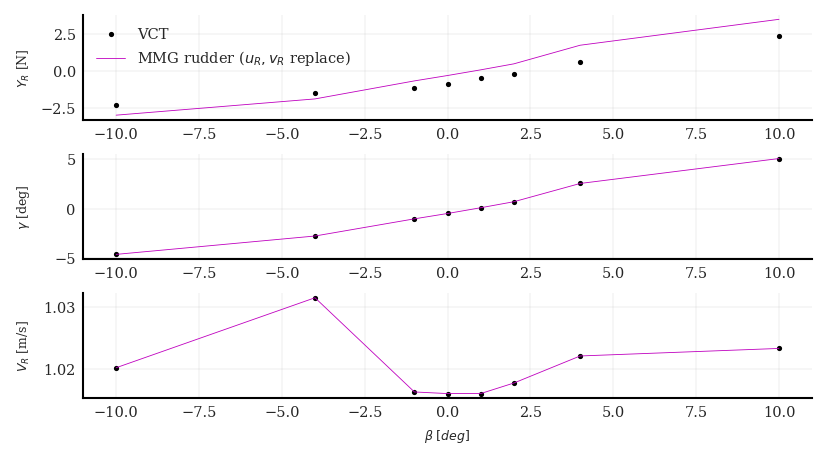

In [120]:
predictions = {
    'MMG_rudder ($u_R,v_R$ replace)':df_prediction_MMG,
    #'MMG_rudder ($RMS(u_R),RMS(v_R)$ replace)':df_prediction_MMG_RMS,
}

fig = plot_VCT(df_VCT_scaled, y_keys=['Y_R','gamma_deg','V_R'], predictions=predictions, test_type='Drift angle', styles=styles);
fig.axes[0].set_ylabel(r'$Y_R$ [N]')
fig.axes[1].set_ylabel(r'$\gamma$ [deg]')
fig.axes[2].set_ylabel(r'$V_R$ [m/s]')

fig.align_ylabels()
fig.suptitle('')
fig.axes[0].set_title('')
fig.axes[1].get_legend().set_visible(False)
fig.axes[2].get_legend().set_visible(False)

for ax in fig.axes:
    ax.grid(True)

paper.save_fig(fig,"drift_angle.svg")

In [121]:
df_prediction_MMG.groupby(by='test type').get_group('Drift angle').sort_values(by='beta')[['beta_deg','v_R','u_R','Y_R']]

,beta_deg,v_R,u_R,Y_R
19,-10.0,-0.076391,0.950522,-2.978380
21,-4.0,-0.046941,0.980504,-1.883970
20,-1.0,-0.016978,0.965564,-0.670359
40,0.0,-0.007842,0.960842,-0.308082
25,1.0,0.001877,0.959625,0.073635
26,2.0,0.012109,0.963966,0.477286
28,4.0,0.043510,0.972064,1.731003
24,10.0,0.086751,0.976017,3.475506


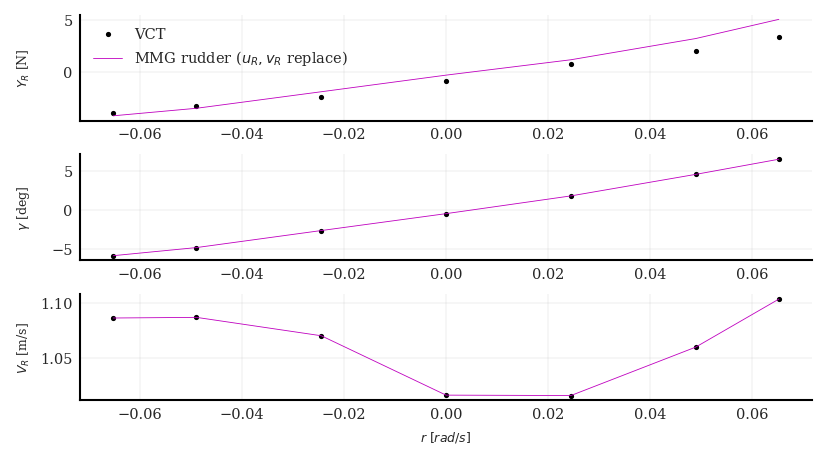

In [122]:
fig = plot_VCT(df_VCT_scaled, y_keys=['Y_R','gamma_deg','V_R'], predictions=predictions, test_type='Circle', styles=styles);
fig.axes[0].set_ylabel(r'$Y_R$ [N]')
fig.axes[1].set_ylabel(r'$\gamma$ [deg]')
fig.axes[2].set_ylabel(r'$V_R$ [m/s]')

fig.align_ylabels()
fig.suptitle('')
fig.axes[0].set_title('')
fig.axes[1].get_legend().set_visible(False)
fig.axes[2].get_legend().set_visible(False)

for ax in fig.axes:
    ax.grid(True)

paper.save_fig(fig,"circle.svg")

In [123]:
df_compare = pd.merge(left=df_VCT_scaled, right=df_prediction_MMG, left_index=True, right_index=True, how='left', suffixes=('','_MMG'))

In [124]:
table = df_compare.loc[[16,10,0,5,],['beta_deg','r','V_R','gamma_deg','Y_R','Y_R_MMG']]

In [125]:
table.to_csv(paper.file_path_with_nb_ref("inflows.csv", directory='tables'), index=False)

In [126]:
df_prediction_MMG.groupby(by='test type').get_group('Circle').sort_values(by='r')[['r','V_R','gamma_deg','Y_R']]

,r,V_R,gamma_deg,Y_R
5,-0.065215,1.086628,-5.828192,-4.251096
6,-0.048911,1.087217,-4.794745,-3.521340
7,-0.024456,1.070370,-2.623424,-1.918503
40,0.000000,1.015960,-0.467608,-0.308082
2,0.024456,1.015575,1.794405,1.182238
1,0.048911,1.059927,4.539388,3.238872
0,0.065215,1.103940,6.470565,5.100294


In [127]:
df_VCT_scaled.groupby(by='test type').get_group('Circle').sort_values(by='r')[['r','V_R','gamma_deg','Y_R']]

,r,V_R,gamma_deg,Y_R
5,-0.065215,1.086628,-5.828192,-3.971883
6,-0.048911,1.087217,-4.794745,-3.305279
7,-0.024456,1.070370,-2.623424,-2.430291
40,0.000000,1.015960,-0.467608,-0.897399
2,0.024456,1.015575,1.794405,0.783660
1,0.048911,1.059927,4.539388,2.011290
0,0.065215,1.103940,6.470565,3.371909


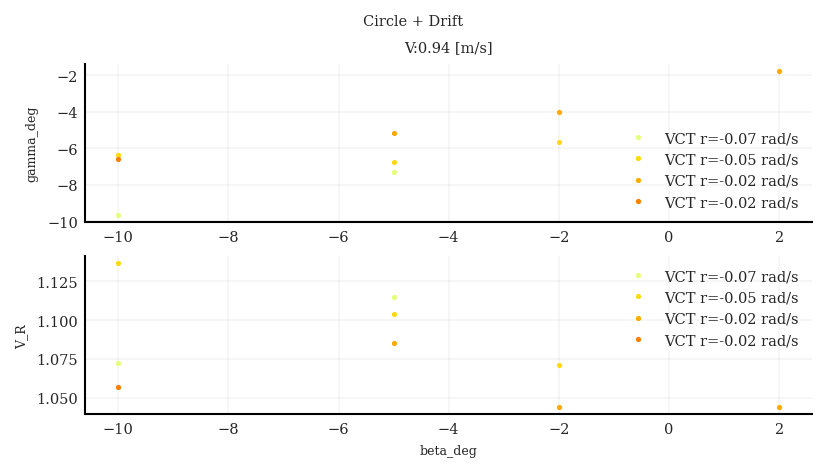

In [128]:
fig = plot_VCT(df_VCT_scaled, y_keys=['gamma_deg','V_R'], test_type='Circle + Drift', styles=styles);

In [129]:
model_MMG = catalog.load(f"{ship_name}.models_VCT_MMG_rudder")["MMG"]()

[11/28/24 10:36:17] INFO     Loading data from 'optiwise.models_VCT_MMG_rudder'                 ]8;id=746531;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=38025;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

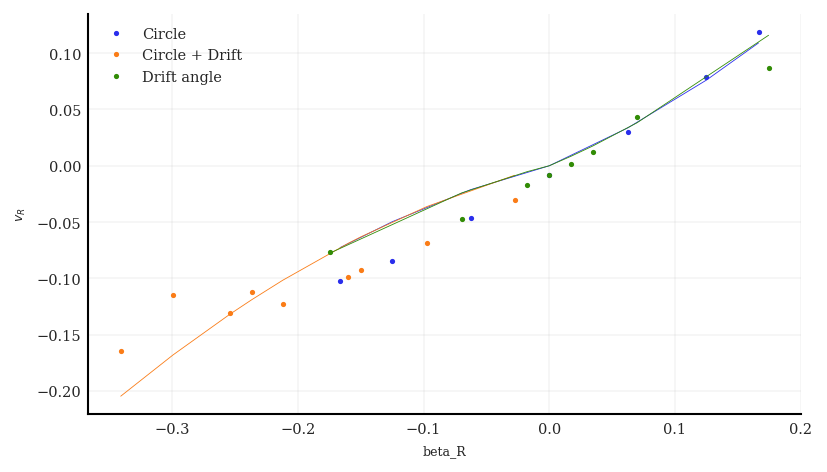

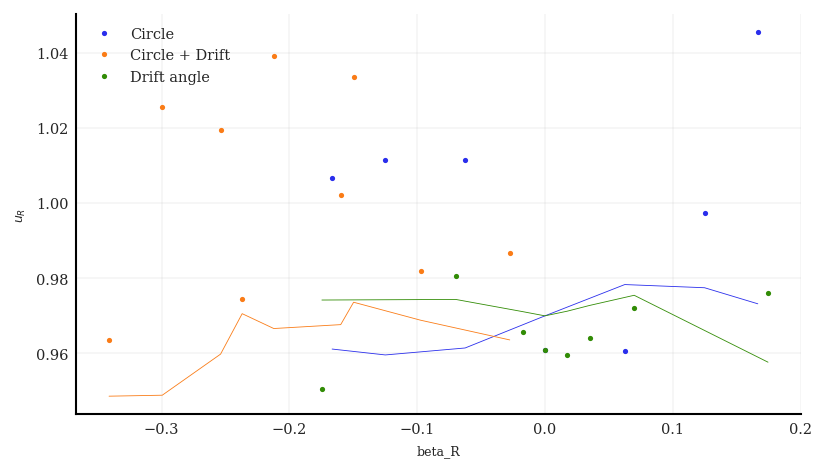

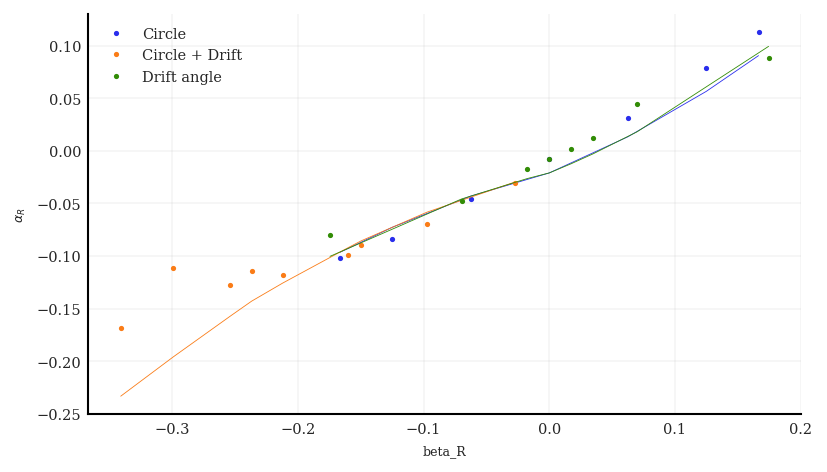

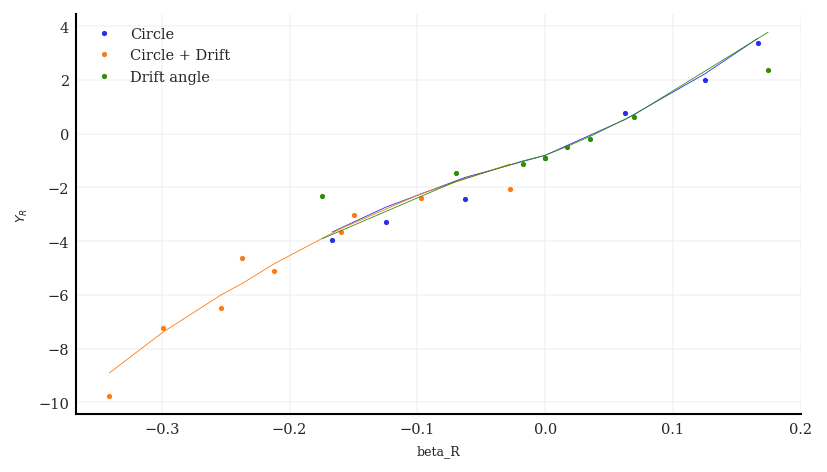

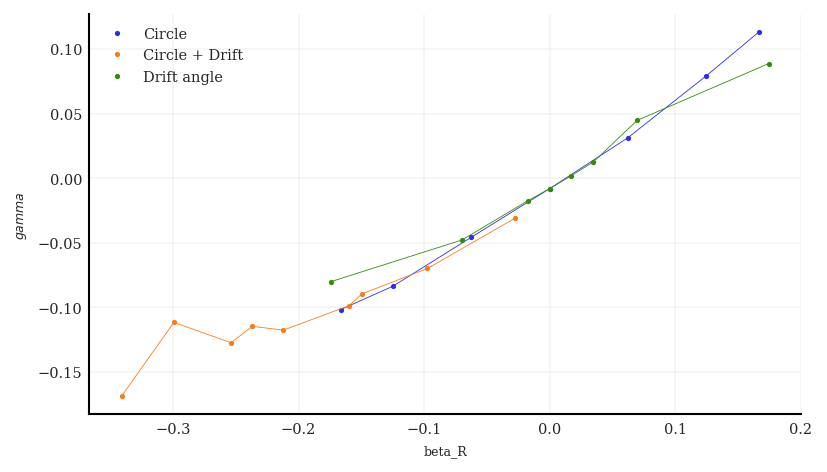

In [130]:

df_prediction_MMG_real = predict(model_MMG, data=df_VCT_scaled)
df_prediction_MMG_real['alpha_R_deg'] = np.rad2deg(df_prediction_MMG_real['alpha_R'])

df_prediction_MMG = pd.DataFrame(rudder.calculate_forces(states_dict=df_VCT_scaled[model.states_str], control=df_VCT_scaled[model.control_keys], calculation={}), index=df_VCT_scaled.index)
columns = list(set(df_VCT_scaled.columns) - set(df_prediction_MMG.columns))
df_prediction_MMG[columns] = df_VCT_scaled[columns]
df_prediction_MMG['model_name'] = 'MMG'
df_prediction_MMG['is_VCT'] = False  # For bokeh plottings
df_prediction_MMG['alpha_R_deg'] = np.rad2deg(df_prediction_MMG['alpha_R'])

mask = df_prediction_MMG['test type'].isin([
    'Drift angle',
    'Circle',
    'Circle + Drift', 
])
df = df_prediction_MMG.loc[mask].copy()


mask = df_prediction_MMG_real['test type'].isin([
    'Drift angle',
    'Circle',
    'Circle + Drift', 
])
df_real = df_prediction_MMG_real.loc[mask].copy()
real_groups = df_real.groupby(by='test type')

keys = ['v_R','u_R','alpha_R','Y_R','gamma']
x_key = 'beta_R'

l_R = model.parameters['l_R']
L = model.ship_parameters['L']
df_VCT_scaled['beta_R'] = df_VCT_scaled['beta'] - l_R/L * df_VCT_scaled['r']/(df_VCT_scaled['U']/L)
df_VCT_scaled['alpha_R'] = df_VCT_scaled['delta'] + np.arctan2(df_VCT_scaled['v_R'],df_VCT_scaled['u_R'])

mask = df_VCT_scaled['test type'].isin([
    'Drift angle',
    'Circle',
    'Circle + Drift', 
])
df_ = df_VCT_scaled.loc[mask]

for key in keys:
    fig,ax=plt.subplots()
    for test_type, group in df_.groupby(by='test type'):
        
        the_plot = group.sort_values(by=x_key).plot(x=x_key,y=key, style='.', label=f"{test_type}", ax=ax)
        color = the_plot.lines[-1].get_color()
    
        real_groups.get_group(test_type).sort_values(by=x_key).plot(x=x_key,y=key, style='-', color=color, label="__none__", ax=ax)

    y_label = symbols.get(key,key)
    ax.set_ylabel(fr'${y_label}$')
    ax.grid()

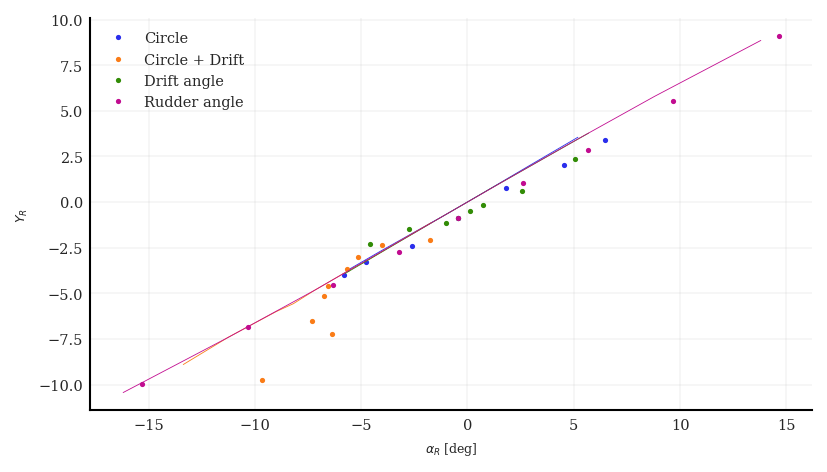

In [131]:
df_VCT_scaled['alpha_R_deg'] = np.rad2deg(df_VCT_scaled['alpha_R'])

mask = df_prediction_MMG_real['test type'].isin([
    'Drift angle',
    'Circle',
    'Circle + Drift', 
    'Rudder angle',
])
df_real = df_prediction_MMG_real.loc[mask].copy()
real_groups = df_real.groupby(by='test type')

mask = df_VCT_scaled['test type'].isin([
    'Drift angle',
    'Circle',
    'Circle + Drift', 
    'Rudder angle',
])

df_ = df_VCT_scaled.loc[mask]
keys = ['Y_R']
x_key = 'alpha_R_deg'

for key in keys:

    if key == x_key:
        continue
    
    fig,ax=plt.subplots()
    for test_type, group in df_.groupby(by='test type'):
        
        the_plot = group.sort_values(by=x_key).plot(x=x_key,y=key, style='.', label=f"{test_type}", ax=ax)
        color = the_plot.lines[-1].get_color()
    
        real_groups.get_group(test_type).sort_values(by=x_key).plot(x=x_key,y=key, style='-', color=color, label="__none__", ax=ax)

    y_label = symbols.get(key,key)
    ax.set_ylabel(fr'${y_label}$')
    ax.set_xlabel(r'$\alpha_R$ [deg]')
    ax.grid()


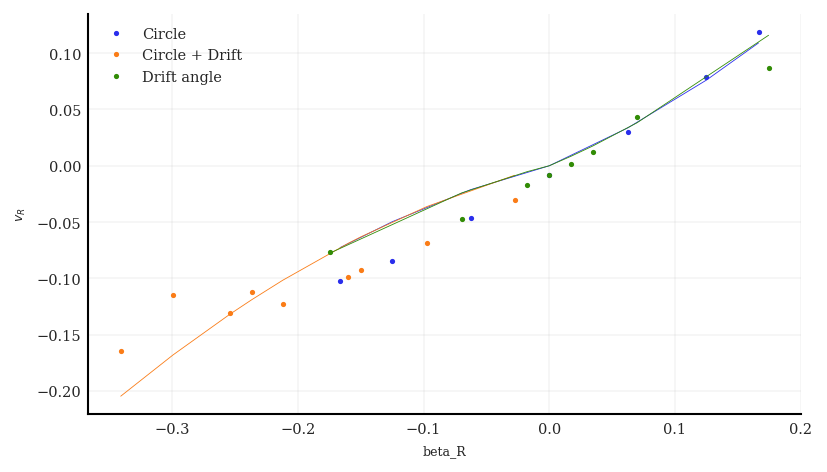

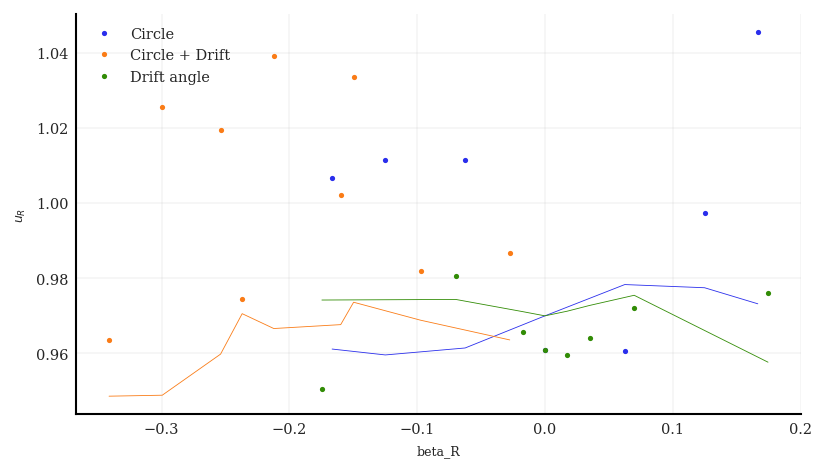

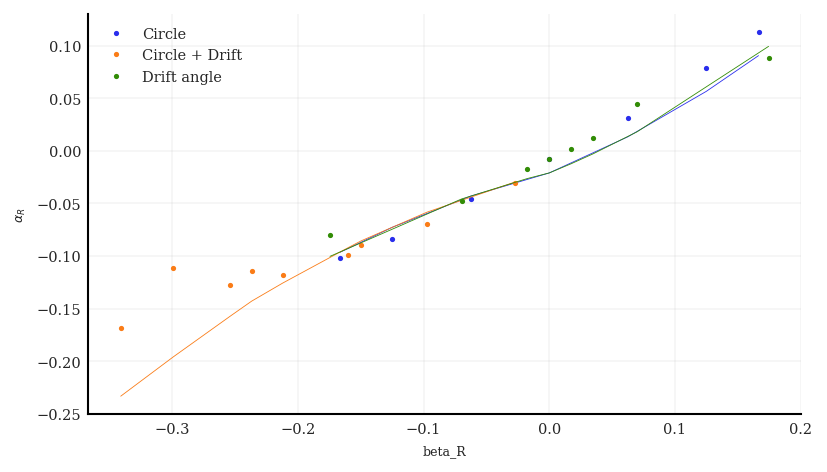

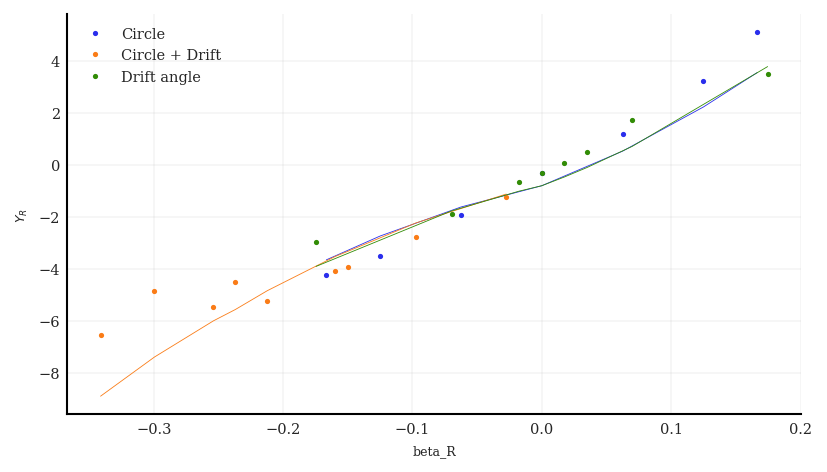

In [132]:
#model_MMG.parameters['w_p']=0.35
#model.parameters['gamma_R_neg']=0.5
#model.parameters['gamma_R_pos']=0.5
#model.parameters['l_R']=1.4*model.ship_parameters['x_R']
#model_MMG.parameters['gamma_R_neg'] = model.parameters['gamma_R_neg']
#model_MMG.parameters['gamma_R_pos'] = model.parameters['gamma_R_pos']
#model_MMG.parameters['l_R'] = model.parameters['l_R']
#model_MMG.parameters['gamma_0']=np.deg2rad(-0.33)

df_prediction_MMG_real = predict(model_MMG, data=df_VCT_scaled)
df_prediction_MMG_real['alpha_R_deg'] = np.rad2deg(df_prediction_MMG_real['alpha_R'])

df_prediction_MMG = pd.DataFrame(rudder.calculate_forces(states_dict=df_VCT_scaled[model.states_str], control=df_VCT_scaled[model.control_keys], calculation={}), index=df_VCT_scaled.index)
columns = list(set(df_VCT_scaled.columns) - set(df_prediction_MMG.columns))
df_prediction_MMG[columns] = df_VCT_scaled[columns]
df_prediction_MMG['model_name'] = 'MMG'
df_prediction_MMG['is_VCT'] = False  # For bokeh plottings
df_prediction_MMG['alpha_R_deg'] = np.rad2deg(df_prediction_MMG['alpha_R'])

mask = df_prediction_MMG['test type'].isin([
    'Drift angle',
    'Circle',
    'Circle + Drift', 
])
df = df_prediction_MMG.loc[mask].copy()


mask = df_prediction_MMG_real['test type'].isin([
    'Drift angle',
    'Circle',
    'Circle + Drift', 
])
df_real = df_prediction_MMG_real.loc[mask].copy()
real_groups = df_real.groupby(by='test type')

keys = ['v_R','u_R','alpha_R','Y_R']
x_key = 'beta_R'

for key in keys:
    fig,ax=plt.subplots()
    for test_type, group in df.groupby(by='test type'):
        
        the_plot = group.sort_values(by=x_key).plot(x=x_key,y=key, style='.', label=f"{test_type}", ax=ax)
        color = the_plot.lines[-1].get_color()
    
        real_groups.get_group(test_type).sort_values(by=x_key).plot(x=x_key,y=key, style='-', color=color, label="__none__", ax=ax)

    y_label = symbols.get(key,key)
    ax.set_ylabel(fr'${y_label}$')
    ax.grid()


In [133]:
#df_prediction_MMG['alpha_R'] = df_prediction_MMG['beta_R'] + df_prediction_MMG['delta']

In [134]:
df_prediction_MMG['alpha_R'] = np.arctan2(df_prediction_MMG['v_R'],df_prediction_MMG['u_R']) + df_prediction_MMG['delta']

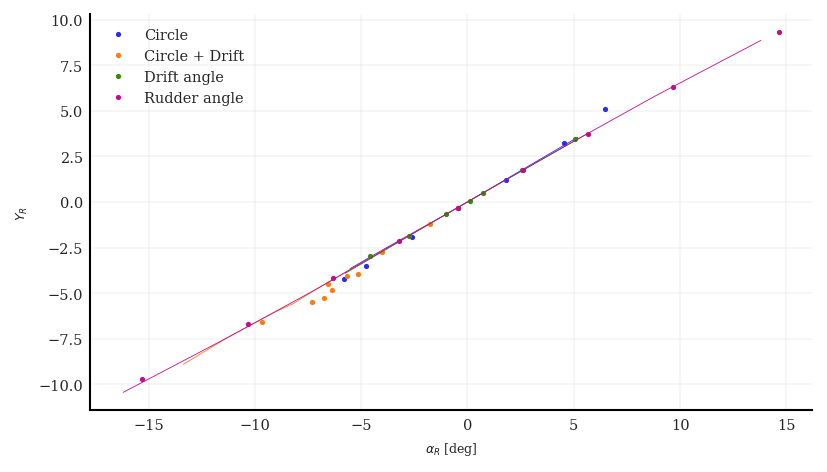

In [135]:
mask = df_prediction_MMG['test type'].isin([
    'Drift angle',
    'Circle',
    'Circle + Drift', 
    'Rudder angle',
])
df = df_prediction_MMG.loc[mask].copy()


mask = df_prediction_MMG_real['test type'].isin([
    'Drift angle',
    'Circle',
    'Circle + Drift', 
    'Rudder angle',
])
df_real = df_prediction_MMG_real.loc[mask].copy()
real_groups = df_real.groupby(by='test type')

keys = ['Y_R']
x_key = 'alpha_R_deg'

for key in keys:

    if key == x_key:
        continue
    
    fig,ax=plt.subplots()
    for test_type, group in df.groupby(by='test type'):
        
        the_plot = group.sort_values(by=x_key).plot(x=x_key,y=key, style='.', label=f"{test_type}", ax=ax)
        color = the_plot.lines[-1].get_color()
    
        real_groups.get_group(test_type).sort_values(by=x_key).plot(x=x_key,y=key, style='-', color=color, label="__none__", ax=ax)

    y_label = symbols.get(key,key)
    ax.set_ylabel(fr'${y_label}$')
    ax.set_xlabel(r'$\alpha_R$ [deg]')
    ax.grid()


In [136]:
def plot_3d(data, data_prediction=None, key = 'V_R',):

    layout = go.Layout(scene = {
                                'xaxis':{'title':'beta'},
                                'yaxis':{'title':'r'},
                                'zaxis':{'title':key},
                        }
                    )
    
    if data_prediction is None:
        fig = go.Figure(layout=layout)
    else:
        fig = go.Figure(data=[go.Surface(z=data_prediction[key].values.reshape((N,N)), 
                                     x=Betas, y=Rs)], layout=layout)
    
    if key in data:
        trace = go.Scatter3d(x=data['beta'], y=data['r'], z=data[key], mode='markers', marker={'color':'black','size':5,})
        fig.add_trace(trace)
    
    fig.update_layout(title=key, autosize=False,
                      width=1000, height=1000,
                      margin=dict(l=65, r=50, b=65, t=90))
    
    fig.show()

In [137]:
mask = df_VCT_scaled['test type'].isin([
    'Drift angle',
    'Circle',
    'Circle + Drift', 
])
df = df_VCT_scaled.loc[mask].copy()

In [138]:
N = 20
betas = np.linspace(df['beta'].min(),df['beta'].max(),N)
rs = np.linspace(df['r'].min(),df['r'].max(),N)
Betas,Rs = np.meshgrid(betas,rs)
data_ = pd.DataFrame(np.tile(df.iloc[0],(N*N,1)), columns=df.columns)
data_['r'] = Rs.reshape((len(data_),1))
data_['beta'] = Betas.reshape((len(data_),1))
data_['u'] = data_['V']*np.cos(data_['beta'])
data_['v'] = -data_['V']*np.sin(data_['beta'])
for key in df:
    data_[key] = data_[key].astype(df[key].dtype)

data_['thrust'] = df['thrust'].max()

result_ = predict(model=model_MMG, data=data_)
result_['gamma'] = np.arctan2(result_['v_R'],result_['u_R'])
result_['gamma_deg'] = np.rad2deg(result_['gamma'])
result_['V_R'] = np.sqrt(result_['u_R']**2 + result_['v_R']**2)

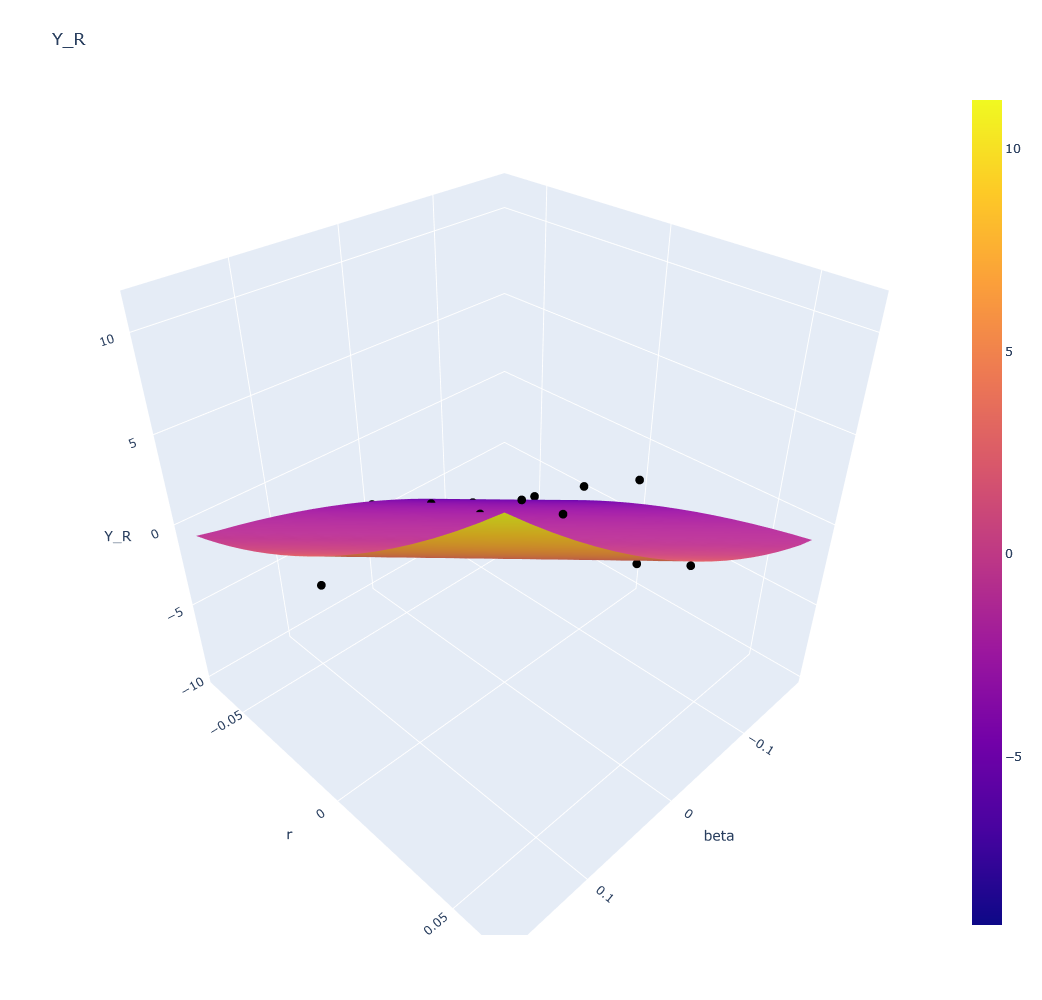

In [139]:
plot_3d(data=df, data_prediction=result_, key='Y_R')

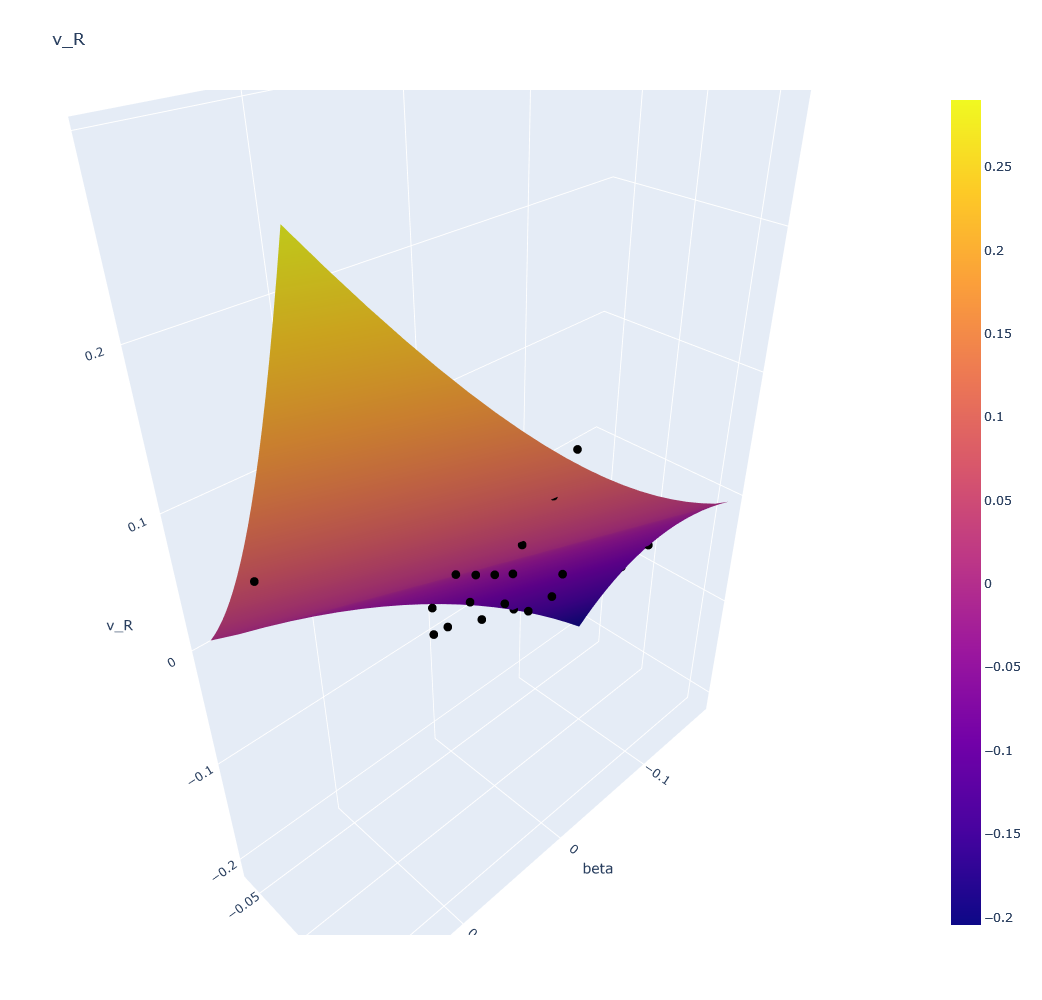

In [140]:
plot_3d(data=df, data_prediction=result_, key='v_R')

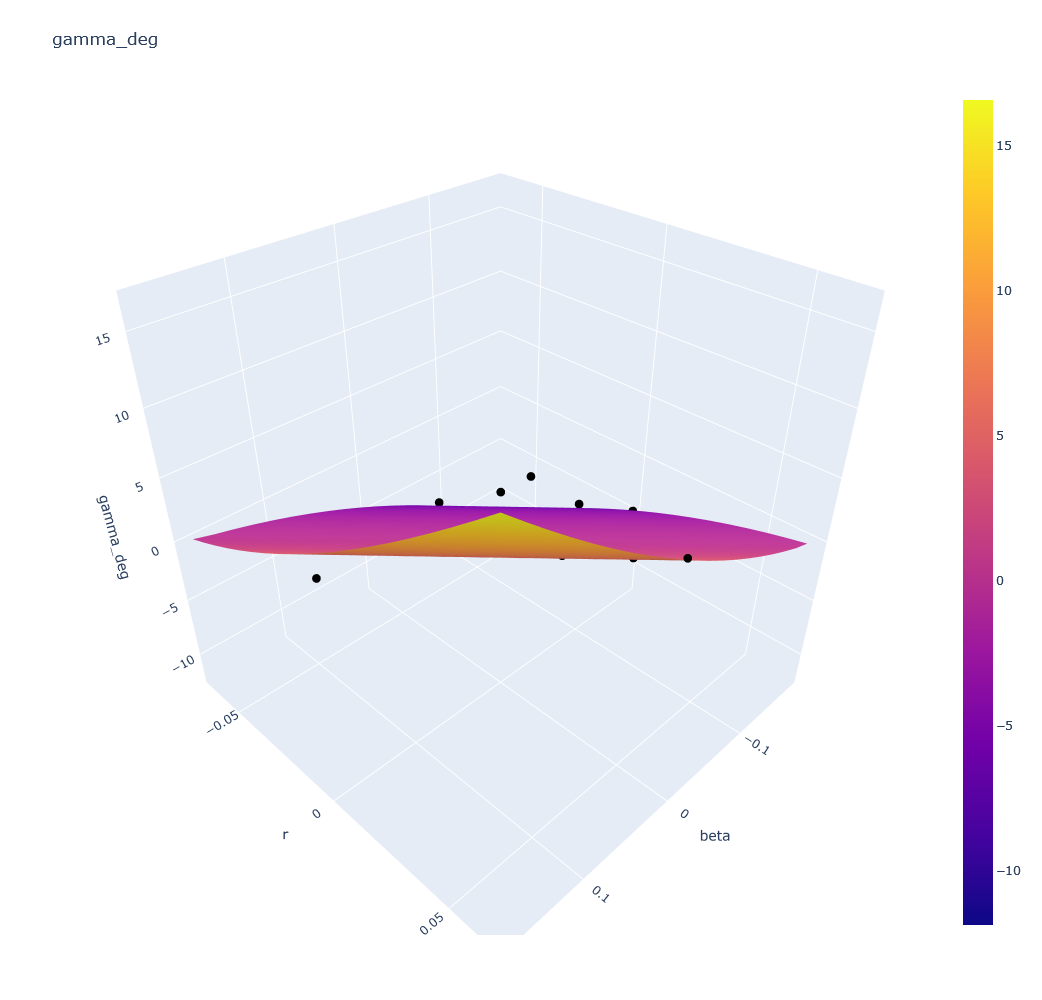

In [141]:
plot_3d(data=df, data_prediction=result_, key='gamma_deg')

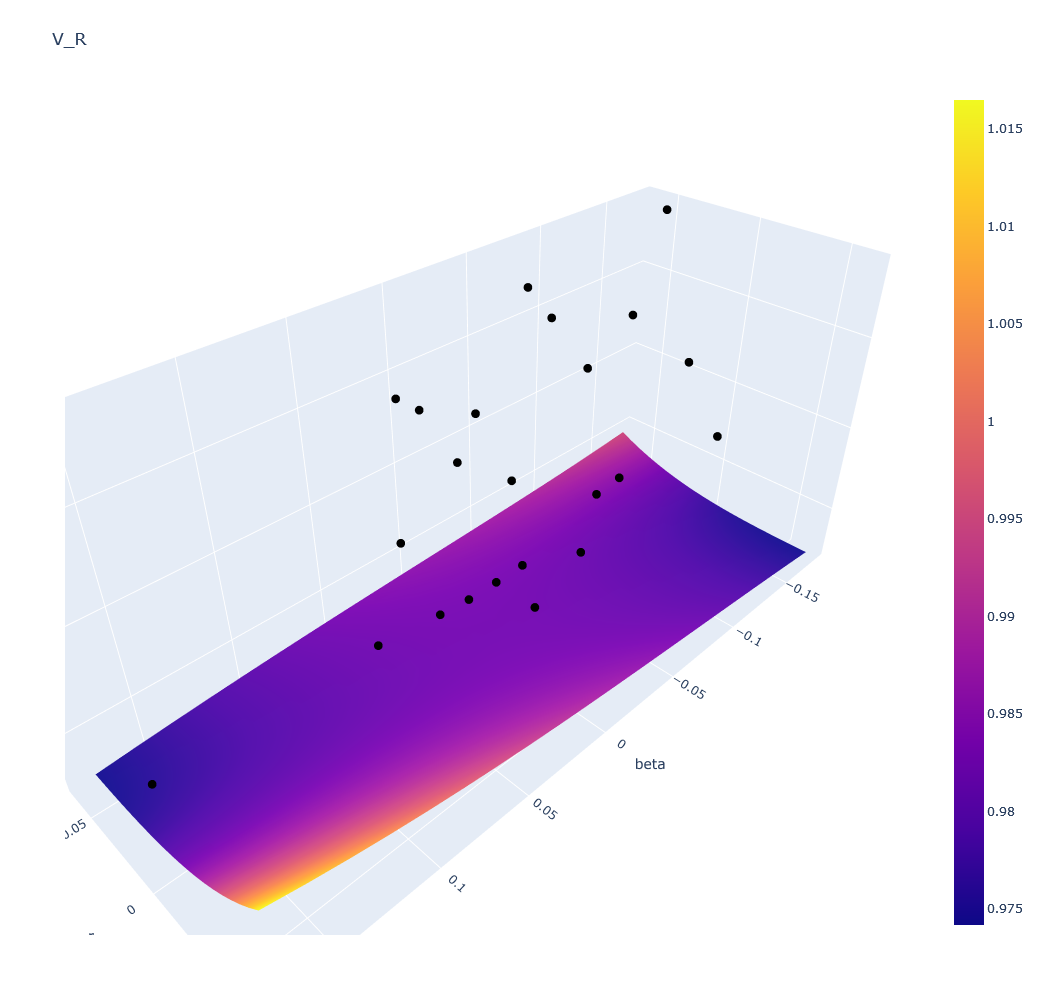

In [142]:
plot_3d(data=df, data_prediction=result_, key='V_R')

## Spanwise

In [143]:
df_VCT_all = pd.read_csv("../../notebooks/OPTIWISE/df_VCT_velocities_optiwise.csv", index_col=0)
df_VCT_all = scale(df_VCT_all)

df_VCT_all['gamma'] = np.arctan2(df_VCT_all['v_R'],df_VCT_all['u_R'])
df_VCT_all['gamma_deg'] = np.rad2deg(df_VCT_all['gamma'])

In [144]:
df_VCT_scaled.groupby('test type').get_group('self propulsion')

,result_file_path,cgnsfile_path,path,model_name,test type,index_no_rudder,model_name_no_rudder,shipflow_version,name_no_rudder,shipflow_version_no_rudder,index,test type_no_rudder,path_no_rudder,result_file_path_no_rudder,name,V,beta,delta,fx,fy,fz,g,mx,my,mz,p,phi,r,rev,rho,thrust,time,torque,u,v,X_D,Y_D,N_D,X_H,Y_H,N_H,X_P,X_R,Y_R,N_R,x0,y0,psi,U,twa,tws,thrust_port,thrust_stbd,u_R,v_R,w_R,V_R,x,z,index_VCT,u_R**2,v_R**2,V_R**2,beta_deg,is_VCT,gamma,gamma_deg,beta_R,alpha_R,alpha_R_deg
40,\\sspa.local\linux\lin-com\2021\41211319-OPTIW...,\\sspa.local\linux\lin-com\2021\41211319-OPTIW...,\\sspa.local\linux\lin-com\2021\41211319-OPTIW...,VCT,self propulsion,\\sspa.local\linux\lin-com\2021\41211319-OPTIW...,Vessel_D_Design_MS_NoRudder,7.1.00,straight,7.1.00,\\sspa.local\linux\lin-com\2021\41211319-OPTIW...,self propulsion,\\sspa.local\linux\lin-com\2021\41211319-OPTIW...,\\sspa.local\linux\lin-com\2021\41211319-OPTIW...,15kn\straight,0.935783,0.0,-0.0,0.204696,-1.128417,-152.636521,9.80665,0.231216,273.848083,2.632618,0.0,0.0,0.0,10.322635,1026.0,14.497669,0.121268,0.257964,0.935783,-0.0,0.204696,-1.128417,2.632618,-10.080964,-0.231018,0.420485,11.453158,-1.167499,-0.897399,2.212133,0.0,0.0,0.0,0.935783,0.0,0.0,7.248834,7.248834,0.960842,-0.007842,-0.038407,1.01596,-2.391544,0.189152,40.0,1.110498,-0.02333,1.251103,0.0,True,-0.008161,-0.467608,0.0,-0.008161,-0.467608


[11/28/24 10:36:21] WARNING  /tmp/ipykernel_88237/329812071.py:10: SettingWithCopyWarning:          ]8;id=194489;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=16436;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                                                                                                                   
                                                                                                                   
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                                                                                                                   
                                                                                                                   

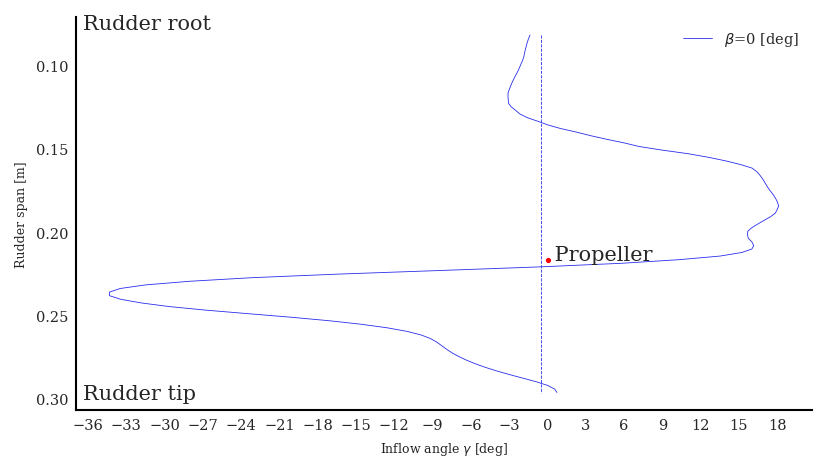

In [145]:
fig,ax=plt.subplots()

id_self_propulsion = df_VCT_scaled.groupby('test type').get_group('self propulsion').index[0]

for id in [id_self_propulsion]:
    label= fr"$\beta$={df_VCT_scaled.loc[id,'beta_deg'].iloc[0]:0.0f} [deg]"
    df = df_VCT_all.groupby(by='index_VCT').get_group(id)
    the_plot = df.plot(x='gamma_deg', y='z', label=label, ax=ax)
    
    df['v_R**2'] = df['v_R'].abs()*df['v_R']
    df_mean = df.mean(numeric_only=True)

    df_mean['v_R_RMS'] = np.sign(df_mean['v_R**2'])*np.sqrt(np.abs(df_mean['v_R**2']))
    df_mean['u_R_RMS'] = np.sign(df_mean['u_R**2'])*np.sqrt(np.abs(df_mean['u_R**2']))
    df_mean['gamma_RMS'] = np.arctan2(df_mean['v_R_RMS'],df_mean['u_R_RMS'])
    df_mean['gamma_deg_RMS'] = np.rad2deg(df_mean['gamma_RMS'])
    
    color = the_plot.lines[-1].get_color()
    ax.plot([df_mean['gamma_deg'],df_mean['gamma_deg']],[df['z'].min(),df['z'].max()],'--', color=color)
    #ax.plot([df_mean['gamma_deg_RMS'],df_mean['gamma_deg_RMS']],[df['z'].min(),df['z'].max()],':', color=color)


z_prop = df['z'].max() - 5.4/ship_data['scale_factor']
ax.plot(0,z_prop,'r.')
ax.text(0,z_prop,' Propeller')


ax.invert_yaxis()
loc = plticker.MultipleLocator(base=3) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
#ax.yaxis.set_major_locator(loc)
ax.grid(False, axis='x')
ax.grid(False, axis='y')
ax.set_xlabel(r'Inflow angle $\gamma$ [deg]')
ax.set_ylabel(r'Rudder span [m]')
xlims = ax.get_xlim()
ylims = ax.get_ylim()
ax.text(0.01,0.97,'Rudder root', transform=ax.transAxes)
ax.text(0.01,0.03,'Rudder tip', transform=ax.transAxes)

paper.save_fig(fig, "inflow_angle_straight.svg")

In [146]:
df_prediction_MMG.head()

,beta,beta_R,gamma_R,eta,U_R,alpha_R,Lambda,f_alpha,F_N,X_R,Y_R,N_R,mx,twa,X_H,v,fz,thrust_port,z,fy,U,thrust,g,psi,shipflow_version_no_rudder,N_H,y0,v_R,tws,p,cgnsfile_path,N_D,x0,result_file_path_no_rudder,Y_H,r,u_R,test type,w_R,x,shipflow_version,alpha_R_deg,u,index,index_VCT,V_R**2,time,gamma_deg,is_VCT,X_P,beta_deg,delta,test type_no_rudder,path_no_rudder,V_R,thrust_stbd,gamma,phi,index_no_rudder,rho,X_D,fx,path,model_name_no_rudder,name_no_rudder,Y_D,v_R**2,result_file_path,model_name,my,u_R**2,rev,torque,V,mz,name
0,-0.0,0.166539,0.699846,0.721088,1.052107,0.112933,1.344307,2.292682,-5.100294,-0.000000,5.100294,-12.188203,0.271463,0.0,-10.995004,0.0,-157.849829,7.366527,0.189078,21.221184,0.935783,14.733054,9.80665,0.0,7.1.00,-40.541722,0.0,0.118565,0.0,0.0,\\sspa.local\linux\lin-com\2021\41211319-OPTIW...,-48.503279,0.0,\\sspa.local\linux\lin-com\2021\41211319-OPTIW...,17.849275,0.065215,1.045405,Circle,0.118286,-2.391544,7.1.00,6.470565,0.935783,\\sspa.local\linux\lin-com\2021\41211319-OPTIW...,0.0,1.373437,0.121268,6.470565,False,11.639113,-0.0,0.000000,NaN,\\sspa.local\linux\lin-com\2021\41211319-OPTIW...,1.103940,7.366527,0.112933,0.0,\\sspa.local\linux\lin-com\2021\41211319-OPTIW...,1026.0,-0.565197,-0.565197,\\sspa.local\linux\lin-com\2021\41211319-OPTIW...,Vessel_D_Design_MS_NoRudder,radius_-3.00,21.221184,0.072942,\\sspa.local\linux\lin-com\2021\41211319-OPTIW...,MMG,293.809992,1.234451,10.322627,0.265392,0.935783,-48.503279,radius_-3.00\15kn
1,-0.0,0.124904,0.649885,0.721088,1.000454,0.079227,1.344307,2.292682,-3.238872,-0.000000,3.238872,-7.739952,0.267453,0.0,-10.662740,0.0,-155.293327,7.524503,0.189078,15.304095,0.935783,15.049006,9.80665,0.0,7.1.00,-30.345015,0.0,0.079180,0.0,0.0,\\sspa.local\linux\lin-com\2021\41211319-OPTIW...,-35.074467,0.0,\\sspa.local\linux\lin-com\2021\41211319-OPTIW...,13.292804,0.048911,0.997316,Circle,0.121209,-2.391544,7.1.00,4.539388,0.935783,\\sspa.local\linux\lin-com\2021\41211319-OPTIW...,1.0,1.281592,0.121268,4.539388,False,11.888714,-0.0,0.000000,NaN,\\sspa.local\linux\lin-com\2021\41211319-OPTIW...,1.059927,7.524503,0.079227,0.0,\\sspa.local\linux\lin-com\2021\41211319-OPTIW...,1026.0,-0.090552,-0.090552,\\sspa.local\linux\lin-com\2021\41211319-OPTIW...,Vessel_D_Design_MS_NoRudder,radius_-4.00,15.304095,0.052933,\\sspa.local\linux\lin-com\2021\41211319-OPTIW...,MMG,284.574690,1.138440,10.322627,0.269366,0.935783,-35.074467,radius_-4.00\15kn
2,-0.0,0.062452,0.574942,0.721088,0.960947,0.031318,1.344307,2.292682,-1.182238,-0.000000,1.182238,-2.825202,0.191101,0.0,-10.258563,0.0,-152.506069,7.555889,0.189078,7.552975,0.935783,15.111778,9.80665,0.0,7.1.00,-15.400894,0.0,0.030090,0.0,0.0,\\sspa.local\linux\lin-com\2021\41211319-OPTIW...,-17.223679,0.0,\\sspa.local\linux\lin-com\2021\41211319-OPTIW...,6.769315,0.024456,0.960475,Circle,0.065758,-2.391544,7.1.00,1.794405,0.935783,\\sspa.local\linux\lin-com\2021\41211319-OPTIW...,2.0,1.208137,0.121268,1.794405,False,11.938305,-0.0,0.000000,NaN,\\sspa.local\linux\lin-com\2021\41211319-OPTIW...,1.015575,7.555889,0.031318,0.0,\\sspa.local\linux\lin-com\2021\41211319-OPTIW...,1026.0,0.365347,0.365347,\\sspa.local\linux\lin-com\2021\41211319-OPTIW...,Vessel_D_Design_MS_NoRudder,radius_-8.00,7.552975,0.022634,\\sspa.local\linux\lin-com\2021\41211319-OPTIW...,MMG,274.785658,1.080008,10.322627,0.268441,0.935783,-17.223679,radius_-8.00\15kn
3,-0.0,0.062452,0.574942,0.721088,0.960947,-0.038495,1.344307,2.292682,1.453028,-0.062133,-1.449488,3.463851,0.621369,0.0,-10.208272,0.0,-152.296890,7.556056,0.189078,4.120464,0.935783,15.112112,9.80665,0.0,7.1.00,-13.631166,0.0,0.030090,0.0,0.0,\\sspa.local\linux\lin-com\2021\41211319-OPTIW...,-9.595539,0.0,\\sspa.local\linux\lin-com\2021\41211319-OPTIW...,5.804516,0.024456,0.960475,Circle + rudder angle,0.065758,-2.391544,7.1.00,-2.205595,0.935783,\\sspa.local\linux\lin-com\2021\41211319-OPTIW...,3.0,1.208137,0.121268,1.794405,False,11.938568,-0.0,-0.069813,NaN,\\sspa.local\linux\lin-com\2021\41211319-

In [147]:
df_VCT_scaled['r_round'] = df_VCT_scaled['r'].round(decimals=2)
df_VCT_scaled.groupby('test type').get_group('Circle').sort_values(by='r')[['r_round']]

,r_round
5,-0.07
6,-0.05
7,-0.02
40,0.00
2,0.02
1,0.05
0,0.07


[11/28/24 10:36:22] WARNING  /tmp/ipykernel_88237/3015912932.py:11: SettingWithCopyWarning:         ]8;id=198716;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=594117;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                                                                                                                   
                                                                                                                   
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                                                                                                                   
                                                                                                                   

                    WARNING  /tmp/ipykernel_88237/3015912932.py:11: SettingWithCopyWarning:         ]8;id=206232;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=24032;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                                                                                                                   
                                                                                                                   
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                                                                                                                   
                                                                                                                   

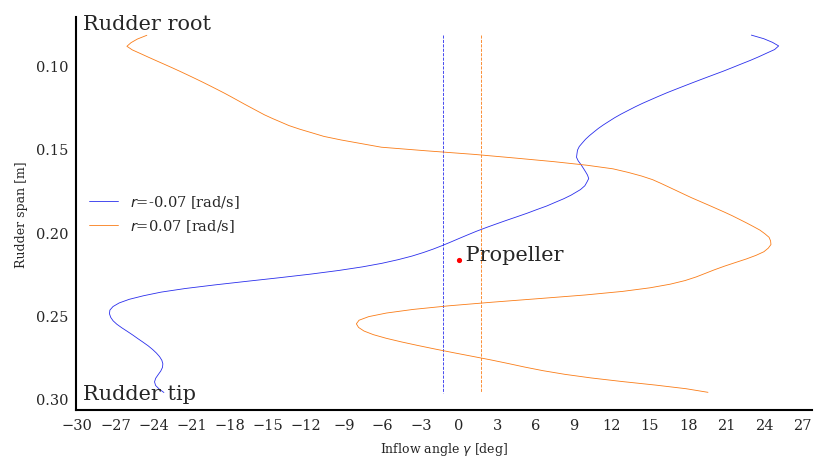

In [148]:
fig,ax=plt.subplots()

id1 = df_VCT_scaled.groupby('test type').get_group('Circle').groupby(by='r_round').get_group(-0.07).index[0]
id2 = df_VCT_scaled.groupby('test type').get_group('Circle').groupby(by='r_round').get_group(0.07).index[0]

for id in [id1,id2]:
    label= fr"$r$={df_VCT_scaled.loc[id,'r']:0.2f} [rad/s]"
    df = df_VCT_all.groupby(by='index_VCT').get_group(id)
    the_plot = df.plot(x='gamma_deg', y='z', label=label, ax=ax)
    
    df['v_R**2'] = df['v_R'].abs()*df['v_R']
    df_mean = df.mean(numeric_only=True)

    df_mean['v_R_RMS'] = np.sign(df_mean['v_R**2'])*np.sqrt(np.abs(df_mean['v_R**2']))
    
    color = the_plot.lines[-1].get_color()
    ax.plot([df_mean['gamma_deg'],df_mean['gamma_deg']],[df['z'].min(),df['z'].max()],'--', color=color)
    #ax.plot([df_mean['v_R_RMS'],df_mean['v_R_RMS']],[df['z'].min(),df['z'].max()],':', color=color)


z_prop = df['z'].max() - 5.4/ship_data['scale_factor']
ax.plot(0,z_prop,'r.')
ax.text(0,z_prop,' Propeller')


ax.invert_yaxis()
loc = plticker.MultipleLocator(base=3) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
#ax.yaxis.set_major_locator(loc)
ax.grid(False, axis='x')
ax.grid(False, axis='y')
ax.set_xlabel(r'Inflow angle $\gamma$ [deg]')
ax.set_ylabel(r'Rudder span [m]')
xlims = ax.get_xlim()
ylims = ax.get_ylim()
ax.text(0.01,0.97,'Rudder root', transform=ax.transAxes)
ax.text(0.01,0.03,'Rudder tip', transform=ax.transAxes)

paper.save_fig(fig, "span_circle.svg")

In [149]:
df_VCT_scaled['C_L'] = (df_VCT_scaled['Y_R']/df_VCT_scaled['V_R']**2)

<Axes: xlabel='gamma'>

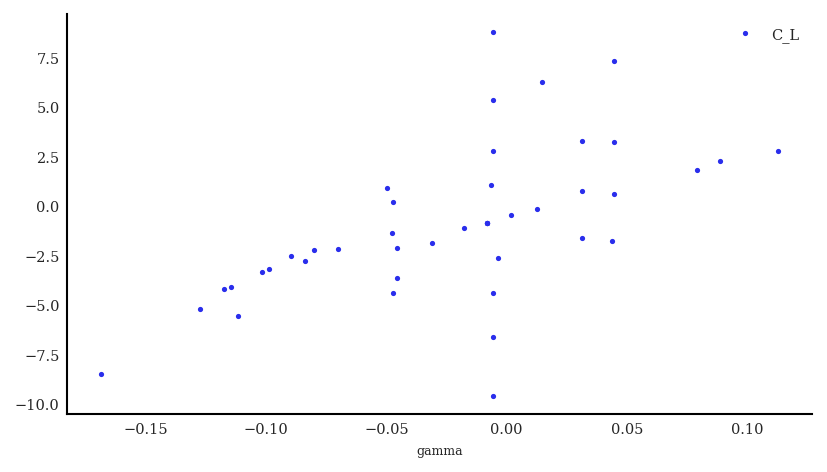

In [150]:
df_VCT_scaled.plot(x='gamma',y='C_L', style='.')

In [151]:
df_VCT_scaled['beta_deg'] = np.round(np.rad2deg(df_VCT_scaled['beta']),1)
df_VCT_scaled.groupby('test type').get_group('Drift angle').sort_values(by='beta')[['beta_deg']]

,beta_deg
19,-10.0
21,-4.0
20,-1.0
40,0.0
25,1.0
26,2.0
28,4.0
24,10.0


                    WARNING  /tmp/ipykernel_88237/1898380662.py:12: SettingWithCopyWarning:         ]8;id=755346;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=150380;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                                                                                                                   
                                                                                                                   
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                                                                                                                   
                                                                                                                   

                    WARNING  /tmp/ipykernel_88237/1898380662.py:12: SettingWithCopyWarning:         ]8;id=500062;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=245585;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                                                                                                                   
                                                                                                                   
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                                                                                                                   
                                                                                                                   

                    WARNING  /tmp/ipykernel_88237/1898380662.py:27: SettingWithCopyWarning:         ]8;id=855597;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=720827;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                                                                                                                   
                                                                                                                   
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                                                                                                                   
                                                                                                                   

                    WARNING  /tmp/ipykernel_88237/1898380662.py:27: SettingWithCopyWarning:         ]8;id=65120;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=761702;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                                                                                                                   
                                                                                                                   
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                                                                                                                   
                                                                                                                   

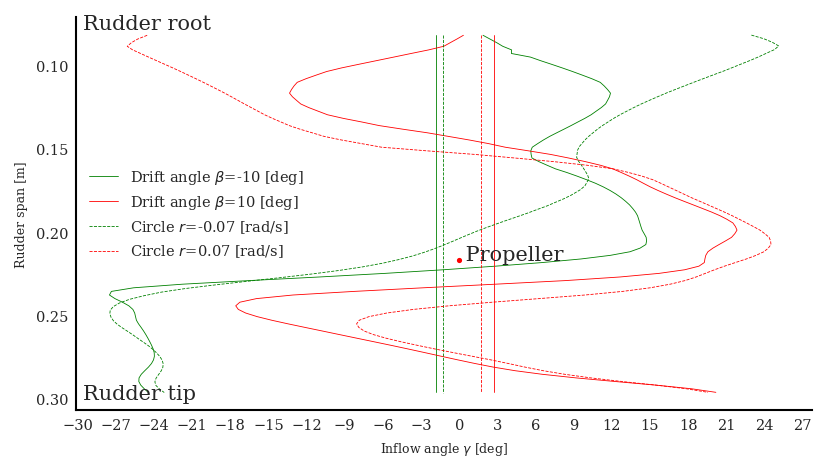

In [152]:
fig,ax=plt.subplots()

colors = ['g','r']
id1 = df_VCT_scaled.groupby('test type').get_group('Drift angle').groupby(by='beta_deg').get_group(-10).index[0]
id2 = df_VCT_scaled.groupby('test type').get_group('Drift angle').groupby(by='beta_deg').get_group(10).index[0]
for id in [id1,id2]:
    label= fr"Drift angle $\beta$={df_VCT_scaled.loc[id,'beta_deg']:0.0f} [deg]"
    df = df_VCT_all.groupby(by='index_VCT').get_group(id)
    color=colors.pop(0)
    the_plot = df.plot(x='gamma_deg', y='z', color=color, label=label, ax=ax)
    
    df['v_R**2'] = df['v_R'].abs()*df['v_R']
    df_mean = df.mean(numeric_only=True)
    
    ax.plot([df_mean['gamma_deg'],df_mean['gamma_deg']],[df['z'].min(),df['z'].max()],'-', color=color)


colors = ['g','r']
id1 = df_VCT_scaled.groupby('test type').get_group('Circle').groupby(by='r_round').get_group(-0.07).index[0]
id2 = df_VCT_scaled.groupby('test type').get_group('Circle').groupby(by='r_round').get_group(0.07).index[0]
for id in [id1,id2]:
    label= fr"Circle $r$={df_VCT_scaled.loc[id,'r']:0.2f} [rad/s]"
    df = df_VCT_all.groupby(by='index_VCT').get_group(id)
    color=colors.pop(0)
    the_plot = df.plot(x='gamma_deg', y='z', color=color, style='--', label=label, ax=ax)
    
    df['v_R**2'] = df['v_R'].abs()*df['v_R']
    df_mean = df.mean(numeric_only=True)
    
    color = the_plot.lines[-1].get_color()
    ax.plot([df_mean['gamma_deg'],df_mean['gamma_deg']],[df['z'].min(),df['z'].max()],'--', color=color)

z_prop = df['z'].max() - 5.4/ship_data['scale_factor']
ax.plot(0,z_prop,'r.')
ax.text(0,z_prop,' Propeller')


ax.invert_yaxis()
loc = plticker.MultipleLocator(base=3) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
#ax.yaxis.set_major_locator(loc)
ax.grid(False, axis='x')
ax.grid(False, axis='y')
ax.set_xlabel(r'Inflow angle $\gamma$ [deg]')
ax.set_ylabel(r'Rudder span [m]')
xlims = ax.get_xlim()
ylims = ax.get_ylim()
ax.text(0.01,0.97,'Rudder root', transform=ax.transAxes)
ax.text(0.01,0.03,'Rudder tip', transform=ax.transAxes)

paper.save_fig(fig, "inflow_angle.svg")